In [1]:
from scipy.io import arff
import numpy as np
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer
from collections import defaultdict
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
import pickle

In [25]:
class surrogate:

    def __init__(self, ntrees=16):
        self.models = {}
        self.ntrees = ntrees

    def get_data(self, data, relevant_params):
        task_ids = data["task_id"].unique()
        data = data[relevant_params + ["task_id"] + ["y"]]
        self.data_dict = defaultdict()
        for task_id in task_ids:
            X_task = data.loc[data["task_id"] == task_id]
            y_task = np.array(X_task["y"], dtype=np.float)
            X_task.drop(["y", "task_id"], 1, inplace=True)
            categorical_names = X_task.select_dtypes(include=['object']).columns
            categorical_ids = [X_task.columns.get_loc(colname) for colname in categorical_names]
            self.data_dict[task_id] = (X_task.as_matrix(), y_task, categorical_ids)
        return task_ids

    def split_data(self, X, y, test_size = 0.15, seed = 42):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        return X_train, X_test, y_train, y_test

    def train_model_rs(self, X, y, categoricals, task_id):
        if task_id in self.models:
            return self.models[task_id]
        param_dist = {"max_depth": np.arange(3, 11),
              "max_features": [1, 2],
              "n_estimators" : np.arange(65, 101),
              "min_samples_split": np.arange(2, 11),
              "bootstrap": [True, False],
              "criterion": ["mse", "mae"]}
        clf = Pipeline(
            steps=[('encoder', sklearn.preprocessing.OneHotEncoder(
                categorical_features=list(categoricals), handle_unknown='ignore')),
                    ('random search', RandomizedSearchCV(RandomForestRegressor(n_estimators=self.ntrees), 
                                                         param_distributions=param_dist,
                                                         n_iter=200, cv=5))])
        clf.fit(X, y)
        self.models[task_id] = clf
        return clf
    
    def train_model(self, X, y, categoricals, task_id):
        if task_id in self.models:
            return self.models[task_id]
        clf = Pipeline(
            steps=[('encoder', sklearn.preprocessing.OneHotEncoder(
                categorical_features=list(categoricals), handle_unknown='ignore')),
                    ('classifier', RandomForestRegressor(n_estimators=self.ntrees))])
        clf.fit(X, y)
        self.models[task_id] = clf
        return clf

    def average_rank(self, val_task_id):
        X_val, y_val, cat_val = self.data_dict[val_task_id]
        total_ranks = np.zeros(len(X_val))
        for task_id in self.data_dict:
            if task_id == val_task_id:
                continue
            X_train, y_train, cat_train = self.data_dict[task_id]
            clf = self.train_model(X_train, y_train, cat_train, task_id)
            y_val_hat = clf.predict(X_val)
            task_ranks = rankdata(y_val_hat, method='average')
            total_ranks = np.add(total_ranks, task_ranks)
        total_ranks = np.divide(total_ranks, len(X_val))
        return total_ranks

    def custom_scorer(self, y, y_hat):
        return pearsonr(y, y_hat)[0]

    def train_surrogate(self, filename="libsvm_svc.arff", relevant_params=["C", "gamma"]):
        data, meta = arff.loadarff(filename)
        df = pd.DataFrame(data)
        task_ids = self.get_data(df, relevant_params)
        pearson_scores = []
        for task_id in task_ids:
            X, y, categoricals = self.data_dict[task_id]
            clf = self.train_model_rs(X, y, categoricals, task_id)
            # y_hat = cross_val_predict(clf, X, y, cv=5)
            # score = pearsonr(y, y_hat)[0]
            # pearson_scores.append(score)
            scores = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(self.custom_scorer))
            mean_score = scores.mean()
            pearson_scores.append(mean_score)
            print("Task %d; Pearson Spearman Correlation: %0.4f (+/- %0.4f)" %(task_id, mean_score, scores.std() * 2))
            # average_rank = self.average_rank(task_id)
            # ar_spearman = pearsonr(y, average_rank)
            # print("Task %d; Average Rank: Pearson Spearman Correlation: %f" % (task_id, ar_spearman[0]))
        return pearson_scores

In [ ]:
s = surrogate()
surrogate_scores = s.train_surrogate()

In [50]:
import pickle
with open('/Users/prernakashyap/Desktop/surrogate_models.pkl', 'wb') as f:
    pickle.dump(s.models, f)

In [40]:
surrogate_scores = []
for task_id in s.models:
    X, y, _ = s.data_dict[task_id]
    pipe = s.models[task_id]
    best_params = pipe.named_steps['random search'].best_params_
    print("Best paramters for task id", task_id, best_params)
    model = RandomForestRegressor(**best_params)
    scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(s.custom_scorer))
    mean_score = scores.mean()
    print("Pearson score", mean_score)
    surrogate_scores.append(mean_score)

Best paramters for task id 3.0 {'n_estimators': 75, 'min_samples_split': 2, 'max_features': 2, 'max_depth': 3, 'criterion': 'mse', 'bootstrap': True}
Pearson score 0.40454500167260327
Best paramters for task id 6.0 {'n_estimators': 96, 'min_samples_split': 9, 'max_features': 1, 'max_depth': 5, 'criterion': 'mse', 'bootstrap': False}
Pearson score 0.3892465174107988
Best paramters for task id 11.0 {'n_estimators': 81, 'min_samples_split': 7, 'max_features': 1, 'max_depth': 4, 'criterion': 'mse', 'bootstrap': True}
Pearson score 0.40466233841073623
Best paramters for task id 12.0 {'n_estimators': 74, 'min_samples_split': 4, 'max_features': 1, 'max_depth': 4, 'criterion': 'mse', 'bootstrap': True}
Pearson score 0.36784572366330537
Best paramters for task id 14.0 {'n_estimators': 91, 'min_samples_split': 2, 'max_features': 1, 'max_depth': 5, 'criterion': 'mse', 'bootstrap': True}
Pearson score 0.4902077314423156
Best paramters for task id 15.0 {'n_estimators': 82, 'min_samples_split': 7, '

Pearson score 0.527107700548868
Best paramters for task id 3896.0 {'n_estimators': 74, 'min_samples_split': 8, 'max_features': 1, 'max_depth': 9, 'criterion': 'mae', 'bootstrap': True}
Pearson score 0.7599481078038385
Best paramters for task id 3899.0 {'n_estimators': 70, 'min_samples_split': 4, 'max_features': 2, 'max_depth': 4, 'criterion': 'mse', 'bootstrap': True}
Pearson score 0.23476483305430085
Best paramters for task id 3902.0 {'n_estimators': 81, 'min_samples_split': 7, 'max_features': 1, 'max_depth': 10, 'criterion': 'mae', 'bootstrap': True}
Pearson score 0.48563301797290004
Best paramters for task id 3903.0 {'n_estimators': 93, 'min_samples_split': 5, 'max_features': 1, 'max_depth': 3, 'criterion': 'mae', 'bootstrap': False}
Pearson score 0.32528183777400865
Best paramters for task id 3904.0 {'n_estimators': 89, 'min_samples_split': 3, 'max_features': 1, 'max_depth': 3, 'criterion': 'mse', 'bootstrap': True}
Pearson score 0.4172755859529014
Best paramters for task id 3913.0

Pearson score 0.4704541489277239
Best paramters for task id 34536.0 {'n_estimators': 94, 'min_samples_split': 3, 'max_features': 1, 'max_depth': 4, 'criterion': 'mse', 'bootstrap': True}
Pearson score 0.7435745307211776
Best paramters for task id 34537.0 {'n_estimators': 94, 'min_samples_split': 3, 'max_features': 1, 'max_depth': 3, 'criterion': 'mse', 'bootstrap': True}
Pearson score 0.47934692693080977
Best paramters for task id 34538.0 {'n_estimators': 93, 'min_samples_split': 5, 'max_features': 2, 'max_depth': 3, 'criterion': 'mse', 'bootstrap': True}
Pearson score 0.4714651821363206
Best paramters for task id 34539.0 {'n_estimators': 88, 'min_samples_split': 2, 'max_features': 2, 'max_depth': 5, 'criterion': 'mae', 'bootstrap': True}
Pearson score 0.2216789821634849
Best paramters for task id 125920.0 {'n_estimators': 79, 'min_samples_split': 9, 'max_features': 1, 'max_depth': 8, 'criterion': 'mse', 'bootstrap': True}
Pearson score 0.3917445600929617
Best paramters for task id 125

In [41]:
# y = alpha * hyperparameter_1 ^ 2 + beta * hyperparameter_2 ^ 2 + gamma * hyperparameter_1 * hyperparameter_2 + delta
# hyperparameter_1 = gamma
# hyperparameter_2 = complexity (C)
class simplified_surrogate:

    def __init__(self, surrogate):
        self.surrogate = surrogate
        self.models = {}

    def train_model(self):
        pearson_scores = []
        for task_id in self.surrogate.data_dict:
            X, y, _ = self.surrogate.data_dict[task_id]
            poly = PolynomialFeatures(2)
            X = poly.fit_transform(X)
            X = np.delete(X, 1, 1)
            X = np.delete(X, 2, 1)
            model = LinearRegression()
            model.fit(X, y)
            self.models[task_id] = model
            # y_hat = cross_val_predict(model, X, y, cv=5)
            # score = pearsonr(y, y_hat)[0]
            scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(self.surrogate.custom_scorer))
            mean_score = scores.mean()
            pearson_scores.append(mean_score)
            # print("Task %d; Pearson Spearman Correlation: %f" % (task_id, score))
        return pearson_scores

    def plot_curve(self, task_id):
        X, y, _ = self.surrogate.data_dict[task_id]
        model = self.models[task_id]
        y_hat = model.predict(np.append(X, X ** 2, axis = 1))
        plt.plot(y_hat, c="blue")
        plt.plot(y, c="red")
        plt.axis("equal")

In [42]:
s_ = simplified_surrogate(s)
simplified_surrogate_scores = s_.train_model()

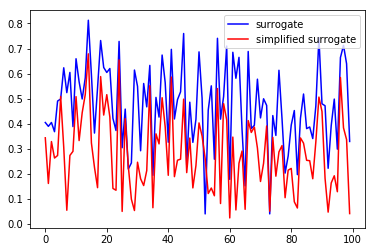

In [43]:
plt.plot(surrogate_scores, color="blue", label="surrogate")
plt.plot(simplified_surrogate_scores, color="red", label="simplified surrogate")
plt.legend()
plt.show()

In [44]:
def draw_plot(data, offset,edge_color, fill_color):
    pos = np.arange(1) + offset 
    bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_xticks=False)
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

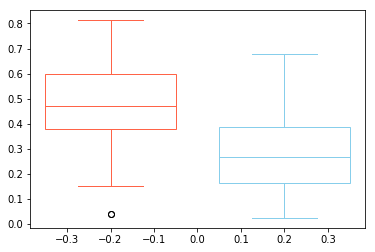

In [45]:
fig, ax = plt.subplots()
draw_plot(surrogate_scores, -0.2, "tomato", "white")
draw_plot(simplified_surrogate_scores, +0.2, "skyblue", "white")
plt.show()
plt.close()

TODO<br>
-> tune RF hyperparameters (no. of trees, no. of features per node)<br>
-> use random search for tuning<br>
-> sklearnbot openml - generating more data<br>
-> Bernd Bischl, Carlos Soares<br>
-> Expected median (~0.5-0.6)<br>

In [46]:
np.median(surrogate_scores)

0.47214542037621016

In [47]:
np.median(simplified_surrogate_scores)

0.2676774655410381